**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -d palmoreck/jupyterlab_numerical:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_numerical
```


Documentación de la imagen de docker `palmoreck/jupyterlab_numerical:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/numerical).

---

Nota basada en [liga1](https://drive.google.com/file/d/1xtkxPCx05Xg4Dj7JZoQ-LusBDrtYUqOF/view?usp=sharing), [liga2](https://drive.google.com/file/d/16-_PvWNaO0Zc9x04-SRsxCRdn5fxebf2/view?usp=sharing)

En esta nota se consideran resolver problemas de la forma:

$$\min f_o(x)$$

con $f_o:\mathbb{R}^n \rightarrow \mathbb{R}$ fuertemente convexa y $f_o \in \mathcal{C}^2(\text{dom}f_o)$ para buscar óptimos locales. Además se asume que los puntos iniciales $x^{(0)}$ de los métodos iterativos están en $\text{dom}f_o$ y los conjuntos $f_o(x^{(0)})$-subnivel son conjuntos cerrados. Ver [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) y [4.1.Optimizacion_numerica_y_machine_learning](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.1.Optimizacion_numerica_y_machine_learning.ipynb) para definiciones utilizadas en esta nota.

También se asume que existe un punto óptimo $x^*$ por lo que el problema tiene solución y el valor óptimo se denota por $p^* = f_o(x^*) = \inf f_o(x)$

Las suposición que una función $f$ sea convexa asegura que una **condición necesaria y suficiente** para que $x^*$ sea óptimo es: $\nabla f(x^*) = 0$ la cual es **en general** es un conjunto de $n$ **ecuaciones no lineales** en $n$ variables y que resuelve el problema de optimización planteado al inicio. 


# Método de Newton

## Método de Newton como un caso particular del método *steepest descent* bajo la norma cuadrática

Consideramos con la norma cuadrática: $P=\nabla ^2 f_o(x^*)$ el método *steepest descent*:

$$\Delta x_{\text{nsd}} = \text{argmin} \{ \nabla f_o(x)^Tv : ||v||_P \leq 1, \nabla f_o(x)^Tv < 0 \} $$ 

se prueba que $\Delta x_{\text{sd}} = - P^{-1} \nabla f_o(x)$.

Ver [4.2.Algoritmos_para_optimizacion_sin_restricciones](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.2.Algoritmos_para_optimizacion_sin_restricciones.ipynb). Entonces:

>**Algoritmo de Newton (visto como un caso particular del método *steepest descent* para matrices Hessianas simétricas definidas positivas)**
>> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$

>> **Repetir** el siguiente bloque para $k=0,1,2,...$

>>> 1. Calcular la Hessiana de $f_o$ y definir $P$ como $P=\nabla ^2 f_o(x^*)$ con $x^*$ óptimo de $f_o$.
>>> 2. Transformar $\hat{x}$ con: $x = P^{-1/2} \hat{x}$ con $\hat{x}$ variable del problema transformado\*.
>>> 3. Calcular la dirección de descenso de Newton $\Delta x_{\text{nt}} = - \nabla ^2 f_o(x)^{-1} \nabla f_o(x)$.
>>> 4. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>>> 5. Hacer la actualización: $x = x + t\Delta x_{\text{nt}}$.

>> **hasta** convergencia (satisfacer criterio de paro).


\*El problema transformado bajo $P$ es:

$$min \hat{f}_o(\hat{x})$$

con $\hat{f}_o (\hat{x}) = f_o(P^{-1/2}\hat{x}) = f_o(x)$ y $x$ variable "original".

Entonces aplicamos descenso en gradiente a $f_o$ pero transformando los datos de entrada de $f_o$ por la matriz raíz cuadrada simétrica\* $P^{-1/2}$.

\*$P^{1/2}$ se nombra **raíz cuadrada simétrica** o ***symmetric squareroot*** y está definida para matrices $P$ simétricas semidefinidas positivas como $P^{1/2}=Qdiag(\lambda_1^{1/2},\dots,\lambda_n^{1/2})Q^T$ con $Q$ y $diag(\lambda_1^{1/2},\dots,\lambda_n^{1/2})$ obtenidas con la **descomposición espectral** de $P$, ver [3.3.d.SVD](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/III.computo_matricial/3.3.d.SVD.ipynb).

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

### Funciones auxiliares

In [2]:
def inc_index(vec,index,h):
    '''
    Auxiliary function for gradient and Hessian computation.
    Args:
        vec (array): numpy array.
        index (int): index.
        h (float):   quantity that vec[index] will be increased.
    Returns:
        vec (array): numpy array vec with vec[index] increased by h.
    '''
    vec[index] +=h
    return vec

In [3]:
def dec_index(vec,index,h=1):
    '''
    Auxiliary function for gradient and Hessian computation.
    Args:
        vec (array): numpy array.
        index (int): index.
        h (float):   quantity that vec[index] will be decreased.
    Returns:
        vec (array): numpy array vec with vec[index] decreased by h.
    '''
    vec[index] -=h
    return vec

In [4]:
def gradient_approximation(f,x,h=1e-8):
    '''
    Numerical approximation of gradient for function f using forward differences.
    Args:
        f (lambda expression): definition of function f.
        x (array): numpy array that holds values where gradient will be computed.
        h (float): step size for forward differences, tipically h=1e-8
    Returns:
        gf (array): numerical approximation to gradient of f.
    '''
    n = x.size
    gf = np.zeros(n)
    f_x = f(x)
    for i in np.arange(n):
        inc_index(x,i,h)
        gf[i] = f(x) - f_x
        dec_index(x,i,h)
    return gf/h

In [5]:
def Hessian_approximation(f,x,h=1e-6):
    '''
    Numerical approximation of Hessian for function f using forward differences.
    Args:
        f (lambda expression): definition of function f.
        x (array): numpy array that holds values where Hessian will be computed.
        h (float): step size for forward differences, tipically h=1e-6
    Returns:
        Hf (array): numerical approximation to Hessian of f.
    '''
    n = x.size
    Hf = np.zeros((n,n))
    f_x = f(x)
    for i in np.arange(n):
        inc_index(x,i,h)
        f_x_inc_in_i = f(x)
        for j in np.arange(i,n):
            inc_index(x,j,h)
            f_x_inc_in_i_j = f(x)
            dec_index(x,i,h)
            f_x_inc_in_j = f(x)
            dif = f_x_inc_in_i_j-f_x_inc_in_i-f_x_inc_in_j+f_x
            Hf[i,j] = dif
            if j != i:
                Hf[j,i] = dif
            dec_index(x,j,h)
            inc_index(x,i,h)
        dec_index(x,i,h)
    return Hf/h**2

In [6]:
def line_search_by_backtracking(f,dir_desc,x,
                                der_direct, alpha=.15, beta=.5):
    """
    Line search that sufficiently decreases f restricted to a ray in the direction dir_desc.
    Args:
        alpha (float): parameter in line search with backtracking, tipically .15
        beta (float): parameter in line search with backtracking, tipically .5
        f (lambda expression): definition of function f.
        dir_desc (array): descent direction.
        x (array): numpy array that holds values where line search will be performed.
        der_direct (float): directional derivative of f.
    Returns:
        t (float): positive number for stepsize along dir_desc that sufficiently decreases f.
    """
    t=1
    if alpha > 1/2:
        print('alpha must be less than or equal to 1/2')
        t=-1
    if beta>1:
        print('beta must be less than 1')
        t=-1;   
    if t!=-1:
        eval1 = f(x+t*dir_desc)
        eval2 = f(x) + alpha*t*der_direct
        while eval1 > eval2:
            t=beta*t
            eval1=f(x+t*dir_desc)
            eval2=f(x)+alpha*t*der_direct
    else:
        t=-1
    return t

In [7]:
def compute_error(x_obj,x_approx):
    '''
    Relative error between x_obj and x_approx.
    '''
    if np.linalg.norm(x_obj) > np.nextafter(0,1):
        Err=np.linalg.norm(x_obj-x_approx)/np.linalg.norm(x_obj)
    else:
        Err=np.linalg.norm(x_obj-x_approx)
    return Err

In [8]:
def gradient_descent(f, x_0, tol, 
                     tol_backtracking, x_ast=None, p_ast=None, maxiter=30):
    '''
    Method of gradient descent to numerically approximate solution of min f.
    Args:
        f (lambda expression): definition of function f.
        x_0 (array): initial point for gradient descent method.
        tol (float): tolerance that will halt method. Controls norm of gradient of f.
        tol_backtracking (float): tolerance that will halt method. Controls value of line search by backtracking.
        x_ast (array): solution of min f, now it's required that user knows the solution...
        p_ast (float): value of f(x_ast), now it's required that user knows the solution...
        maxiter (int): maximum number of iterations
    Returns:
        x (array): numpy array, approximation of x_ast.
        iteration (int): number of iterations.
        Err_plot (array): numpy array of absolute error between p_ast and f(x) with x approximation.
                          of x_ast. Useful for plotting.
        x_plot (array): numpy array that containts in columns vector of approximations. Last column
                        contains x, approximation of solution. Useful for plotting.
    '''
    iteration = 0
    x = x_0
    
    feval = f(x)
    gfeval = gradient_approximation(f,x)

    normgf = np.linalg.norm(gfeval)
    
    Err_plot_aux = np.zeros(maxiter)
    Err_plot_aux[iteration]=math.fabs(feval-p_ast)
    
    Err = compute_error(x_ast,x)
    n = x.size
    x_plot = np.zeros((n,maxiter))
    x_plot[:,iteration] = x
    
    print('I    Normagf   Error x_ast   Error p_ast   line search')
    print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {}'.format(iteration,normgf,Err,Err_plot_aux[iteration],"---"))
    iteration+=1
    while(normgf>tol and iteration < maxiter):
        dir_desc = -gfeval
        der_direct = gfeval.dot(dir_desc)
        t = line_search_by_backtracking(f,dir_desc,x,der_direct)
        x = x + t*dir_desc
        feval = f(x)
        gfeval = gradient_approximation(f,x)
        normgf = np.linalg.norm(gfeval)
        Err_plot_aux[iteration] = math.fabs(feval-p_ast);
        x_plot[:,iteration] = x
        Err = compute_error(x_ast,x)
        print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {:0.2e}'.format(iteration,normgf,Err,
                                                                      Err_plot_aux[iteration],t))
        if t<tol_backtracking: #if t is less than tol_backtracking then we need to check the reason
            iter_salida=iteration
            iteration = maxiter
        iteration+=1
    print('{} {:0.2e}'.format("Error of x with respect to x_ast:",Err))
    print('{} {}'.format("Approximate solution:", x))
    cond = Err_plot_aux > np.finfo(float).eps*10**(-2)
    Err_plot = Err_plot_aux[cond]
    x_plot = x_plot[:,~np.all(x_plot == 0,axis=0)]
    if iteration == maxiter and t < tol_backtracking:
        print("Backtracking value less than tol_backtracking, check approximation")
        iteration=iter_salida
    return [x,iteration,Err_plot,x_plot]

1) $$\min \quad e^{(x_1+3x_2-0.1)}+e^{x_1-3x_2-0.1}+e^{-x_1-0.1}$$

In [12]:
fo = lambda x: math.exp(x[0]+3*x[1]-0.1)+math.exp(x[0]-3*x[1]-0.1)+math.exp(-x[0]-0.1)

In [13]:
x_ast=np.array([-3.4654e-01,-7.6725e-06])

In [14]:
P=Hessian_approximation(fo,x_ast)

In [15]:
P

array([[ 2.55884203e+00, -4.44089210e-04],
       [-4.44089210e-04,  1.15165655e+01]])

In [16]:
def coord_transform(x):
    eigenvalues, eigenvectors = np.linalg.eig(P)       
    return eigenvectors@((eigenvalues**(-1/2))*(np.transpose(eigenvectors)@x))

In [17]:
fo_transf = lambda x: fo(coord_transform(x))

In [18]:
x_ast = coord_transform(x_ast)

In [19]:
x_ast

array([-2.16636502e-01, -7.93837398e-06])

In [20]:
x_0 = np.array([0,0],dtype=float)
tol=1e-8
tol_backtracking=1e-14
maxiter=50
p_ast=fo_transf(x_ast)
[x,total_of_iterations,Err_plot,x_plot]=gradient_descent(fo_transf, x_0,tol, tol_backtracking, x_ast, p_ast, maxiter)

I    Normagf   Error x_ast   Error p_ast   line search
0    5.66e-01    1.00e+00    9.80e-02     ---
1    1.13e-02    1.61e+00    5.72e-02     1.00e+00
2    2.03e-06    1.56e+00    5.73e-02     1.00e+00
3    8.88e-08    1.56e+00    5.73e-02     1.00e+00
4    0.00e+00    1.56e+00    5.73e-02     5.00e-01
Error of x with respect to x_ast: 1.56e+00
Approximate solution: [-5.54392310e-01  3.08197912e-05]


In [21]:
x

array([-5.54392310e-01,  3.08197912e-05])

In [22]:
total_of_iterations

5

In [23]:
Err_plot.shape

(5,)

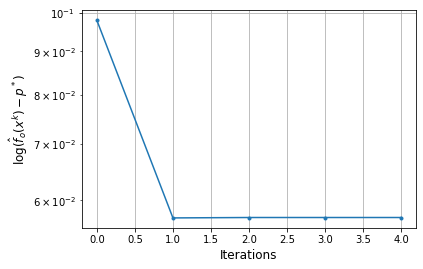

In [24]:
plt.yscale('log') #escala logarítmica en el eje vertical
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\log(\hat{f}_o(x^k)-p^*)$',size=12)
plt.xlabel('Iterations',size=12)
plt.grid()
plt.show()

In [25]:
x_plot.shape

(2, 4)

In [26]:
x_plot[:,0]

array([-5.65651348e-01, -1.48325796e-05])

In [27]:
x_plot[:,-1]

array([-5.54392310e-01,  3.08197912e-05])

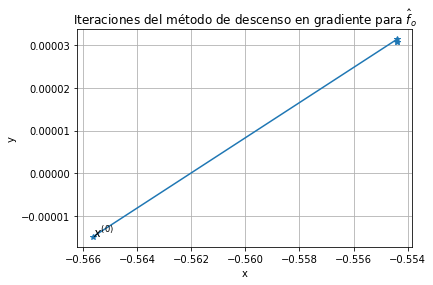

In [28]:
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.ylabel('y')
plt.xlabel('x')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.title('Iteraciones del método de descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

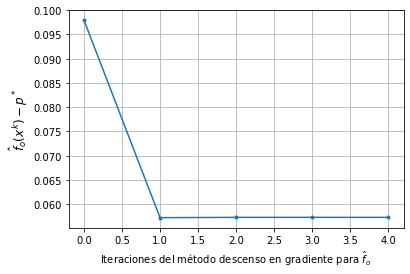

In [29]:
plt.plot(np.arange(Err_plot.size),Err_plot,'.-')
plt.ylabel('$\hat{f}_o(x^k)-p^*$',size=12)
plt.xlabel('Iteraciones del método descenso en gradiente para $\hat{f}_o$')
plt.grid()
plt.show()

**Comentario:** en esta gráfica se observa una convergencia **lineal** del método de descenso en gradiente para $f_o$ transformada.

In [30]:
def coord_transform_2(x):
    eigenvalues, eigenvectors = np.linalg.eig(P)      
    return eigenvectors@((eigenvalues**(-1/2)).reshape(x.shape[0],1)*(eigenvectors@x))

In [31]:
z=lambda x_mesh,y_mesh: np.exp(x_mesh+3*y_mesh-0.1)+np.exp(x_mesh-3*y_mesh-0.1)+np.exp(-x_mesh-0.1)


**Curvas de nivel de $f_o$ transformada**

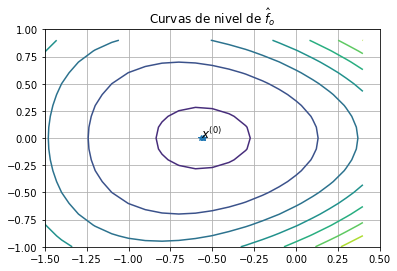

In [32]:
density=1e-1
xl=-1.5
yl=-1
xr=.5
yr=1
x_p=np.arange(xl,xr,density)
y_p=np.arange(yl,yr,density)
x_y_p_t = coord_transform_2(np.row_stack((x_p,y_p)))
x_p_t = x_y_p_t[0,:]
y_p_t = x_y_p_t[1,:]
x_mesh,y_mesh = np.meshgrid(x_p_t,y_p_t)
plt.xlim(-1.5, .5)
plt.ylim(-1, 1)
plt.contour(x_p,y_p,z(x_mesh,y_mesh))
plt.plot(x_plot[0,:],x_plot[1,:],'-*')
plt.annotate('$x^{(0)}$',(x_plot[0,0],x_plot[1,0]),fontsize=12)
plt.grid()
plt.title("Curvas de nivel de $\hat{f}_o$")
plt.show()

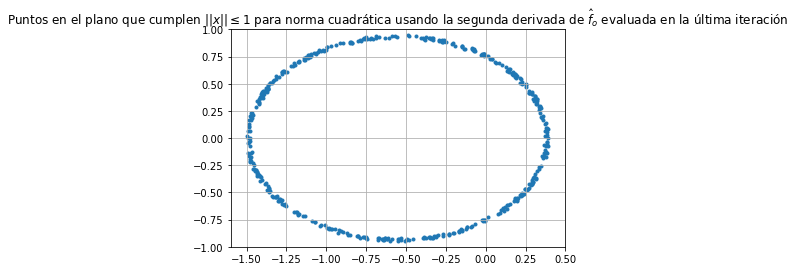

In [33]:
x_k = x_plot[:,-1]
Hf_x_k = Hessian_approximation(fo_transf,x_k)
x_k = x_k.reshape(2,1)
norm_cuad = lambda z : np.sum((z-x_k)*(Hf_x_k@(z-x_k)),axis=0)
density_p=int(2.5*10**4)
z_p=np.random.uniform(-2,1,(2,density_p))
lim_sup=.9
lim_inf=.85
ind=(norm_cuad(z_p)<=lim_sup) & (lim_inf<=norm_cuad(z_p))
z_p_subset = z_p[:,ind]
plt.xlim(-1.6, .5)
plt.ylim(-1, 1)
plt.scatter(z_p_subset[0,:],z_p_subset[1,:],marker='.')
plt.title('Puntos en el plano que cumplen $||x|| \leq 1$ para norma cuadrática usando la segunda derivada de $\hat{f}_o$ evaluada en la última iteración')
plt.grid()
plt.show()

In [34]:
np.linalg.cond(Hf_x_k)

1.0008884940026654

**Obsérvese que la Hessiana con la transformación de $f_o$ está muy bien condicionada**.

## Método de Newton

>**Algoritmo** de Newton
>> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$

>> **Repetir** el siguiente bloque para $k=0,1,2,...$

>>> 1. Calcular la dirección de descenso de Newton $\Delta x_{\text{nt}} = - \nabla ^2 f_o(x)^{-1} \nabla f_o(x)$.
>>> 2. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>>> 3. Hacer la actualización: $x = x + t\Delta x_{\text{nt}}$.

>> **hasta** convergencia (satisfacer criterio de paro).


Otra forma de aplicar el método de Newton.

Falta definir el decremento de Newton

In [109]:
def Newtons_method(f, x_0, tol, 
                   tol_backtracking, x_ast=None, p_ast=None, maxiter=30):
    '''
    Method of gradient descent to numerically approximate solution of min f.
    Args:
        f (lambda expression): definition of function f.
        x_0 (array): initial point for gradient descent method.
        tol (float): tolerance that will halt method. Controls norm of gradient of f.
        tol_backtracking (float): tolerance that will halt method. Controls value of line search by backtracking.
        x_ast (array): solution of min f, now it's required that user knows the solution...
        p_ast (float): value of f(x_ast), now it's required that user knows the solution...
        maxiter (int): maximum number of iterations
    Returns:
        x (array): numpy array, approximation of x_ast.
        iteration (int): number of iterations.
        Err_plot (array): numpy array of absolute error between p_ast and f(x) with x approximation.
                          of x_ast. Useful for plotting.
        x_plot (array): numpy array that containts in columns vector of approximations. Last column
                        contains x, approximation of solution. Useful for plotting.
    '''
    iteration = 0
        
    x = x_0
    
    feval = f(x)
    gfeval = gradient_approximation(f,x)

    normgf = np.linalg.norm(gfeval)
    
    Err_plot_aux = np.zeros(maxiter)
    Err_plot_aux[iteration]=math.fabs(feval-p_ast)
    
    Err = compute_error(x_ast,x)
    n = x.size
    x_plot = np.zeros((n,maxiter))
    x_plot[:,iteration] = x
    
    print('I    Normagf   Error x_ast   Error p_ast   line search')
    print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {}'.format(iteration,normgf,Err,Err_plot_aux[iteration],"---"))
    iteration+=1
    while(normgf>tol and iteration < maxiter):
        dir_desc = -gfeval
        der_direct = gfeval.dot(dir_desc)
        t = line_search_by_backtracking(f,dir_desc,x,der_direct)
        x = x + t*np.linalg.solve(P,dir_desc)
        feval = f(x)
        gfeval = gradient_approximation(f,x)
        normgf = np.linalg.norm(gfeval)
        Err_plot_aux[iteration] = math.fabs(feval-p_ast);
        x_plot[:,iteration] = x
        Err = compute_error(x_ast,x)
        print('{}    {:0.2e}    {:0.2e}    {:0.2e}     {:0.2e}'.format(iteration,normgf,Err,
                                                                      Err_plot_aux[iteration],t))
        if t<tol_backtracking: #if t is less than tol_backtracking then we need to check the reason
            iter_salida=iteration
            iteration = maxiter
        iteration+=1
    print('{} {:0.2e}'.format("Error of x with respect to x_ast:",Err))
    print('{} {}'.format("Approximate solution:", x))
    cond = Err_plot_aux > np.finfo(float).eps*10**(-2)
    Err_plot = Err_plot_aux[cond]
    #x_plot = x_plot[:,~np.all(x_plot == 0,axis=0)]
    x_plot = x_plot[:,:iteration]
    if iteration == maxiter and t < tol_backtracking:
        print("Backtracking value less than tol_backtracking, check approximation")
        iteration=iter_salida
    return [x,iteration,Err_plot,x_plot]

**Referencias:**

* S. P. Boyd, L. Vandenberghe, Convex Optimization, Cambridge University Press, 2009.
